In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

First thing I want to do is to check if MPS is available since I am using Apple M2 Chip and would like to use the device GPU

In [2]:
def check_mps_available():
  if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
      print("MPS not available because PyTorch was not built with MPS enabled"
          )
    else:
      print("MPS not available because the current MacOS version is not 12.3+ and /or you do not have an MPS-enabled device")
      
    return False
  return True

def get_device():
  if check_mps_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
  else:
    device = torch.device('cpu')
    print("Using CPU")
  return device
  

## SimpleNN
A simple neural network model for binary classification.

### Parameters:
- `input_size` (int, default=2): Number of input features
- `hidden_size` (int, default=5): Number of neurons in hidden layer
- `output_size` (int, default=1): Number of output neurons

### Architecture:
1. First Linear Layer: input_size → hidden_size
2. ReLU Activation
3. Second Linear Layer: hidden_size → output_size

### Usage Example:
```python
model = SimpleNN(input_size=2, hidden_size=5, output_size=1)

In [3]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=5, output_size=1):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

## BinaryClassifier Class

Handles the training and evaluation logic for binary classification.

### Parameters:
- `model`: PyTorch model (SimpleNN instance)
- `device`: Computing device (CPU/MPS)
- `learning_rate` (float, default=0.01): Learning rate for optimizer

### Key Methods:
1. `train_step(X, y)`:
   - Performs one training iteration
   - Returns loss value

2. `evaluate(X, y)`:
   - Evaluates model on given data
   - Returns accuracy

### Components:
- Loss Function: Binary Cross Entropy with Logits
- Optimizer: Stochastic Gradient Descent (SGD)

### Usage Example:
```python
classifier = BinaryClassifier(model, device, learning_rate=0.01)

In [102]:
class BinaryClassifier:
    def __init__(self, model, device, learning_rate=0.01, optimizer = 'Adam'):
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.BCEWithLogitsLoss()
        if optimizer == 'Adam':
            self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer == 'SGD':
            self.optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
    def train_step(self, X, y):
        """Single training step"""
        self.model.train() # Set the model to training mode
        self.optimizer.zero_grad() # Reset gradients
        outputs = self.model(X) # Forward pass: Get model predictions
        loss = self.criterion(outputs, y) # Compute loss
        loss.backward() # Backpropagation: Compute gradients
        self.optimizer.step() # Update model parameters
        return loss.item()
    
    def evaluate(self, X, y):
        """Evaluate model on given data"""
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X)
            predictions = (torch.sigmoid(outputs) >= 0.5).float()
            accuracy = (predictions == y).float().mean()
        return accuracy.item()



## DataManager Class

Handles all data-related operations including generation, splitting, and tensor conversion.

### Parameters:
- `device`: Computing device (CPU/MPS)

### Key Methods:
1. `generate_data(n_samples=1000, random_seed=42)`:
   - Creates synthetic dataset
   - Returns X (features) and y (labels)

2. `split_data(X, y, train_size=0.8)`:
   - Splits data into training and validation sets
   - Returns (X_train, y_train), (X_val, y_val)

3. `to_tensor(X, y)`:
   - Converts numpy arrays to PyTorch tensors
   - Moves tensors to specified device

### Usage Example:
```python
data_manager = DataManager(device)
X, y = data_manager.generate_data()

In [70]:
class DataManager:
    def __init__(self, device):
        self.device = device
    
    def generate_data(self, n_samples=1000, random_seed=42):
        """Generate linear synthetic data"""
        np.random.seed(random_seed)
        X = np.random.randn(n_samples, 2)
        y = (X[:, 0] + X[:, 1] > 0).astype(np.float32)
        return X, y
        
    def generate_circular_data(self, n_samples=1000, random_seed=42):
        """Generate circular boundary dataset"""
        np.random.seed(random_seed)
        # Generate points with random radius and angle
        r = np.random.uniform(0, 2, n_samples)
        theta = np.random.uniform(0, 2*np.pi, n_samples)
        
        # Convert to Cartesian coordinates
        X = np.column_stack([
            r * np.cos(theta),
            r * np.sin(theta)
        ])
        
        # Label points: 1 if in the ring (0.5 < r < 1.0), 0 otherwise
        y = ((r > 0.5) & (r < 1.0)).astype(np.float32)
        return X, y
    
    def generate_xor_data(self, n_samples=1000, random_seed=42):
        """Generate XOR-like dataset"""
        np.random.seed(random_seed)
        # Generate points in 4 quadrants
        X = np.random.uniform(-1, 1, (n_samples, 2))
        # XOR labels: 1 if x,y have same sign, 0 otherwise
        y = ((X[:, 0] * X[:, 1]) > 0).astype(np.float32)
        return X, y
    
    def split_data(self, X, y, train_size=0.8):
        """Split data into train and validation sets"""
        split_idx = int(len(X) * train_size)
        return (X[:split_idx], y[:split_idx]), (X[split_idx:], y[split_idx:])
    
    def to_tensor(self, X, y):
        """Convert numpy arrays to PyTorch tensors"""
        X_tensor = torch.FloatTensor(X).to(self.device)
        y_tensor = torch.FloatTensor(y).view(-1, 1).to(self.device)
        return X_tensor, y_tensor
    
    def plot_dataset(self, X, y, title="Dataset Visualization", ax=None):
        """
        Plot dataset either on given axes or create new figure
        
        Parameters:
            X: feature data
            y: labels
            title: plot title
            ax: matplotlib axes (optional). If None, creates new figure
        """
        if ax is None:
            plt.figure(figsize=(8, 6))
            ax = plt.gca()
            
        # Split data by class
        class_0 = X[y == 0]
        class_1 = X[y == 1]
        
        # Plot each class
        ax.scatter(class_0[:, 0], class_0[:, 1], c='blue', label='Class 0', alpha=0.5)
        ax.scatter(class_1[:, 0], class_1[:, 1], c='green', label='Class 1', alpha=0.5)
        
        ax.set_title(title)
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.legend()
        ax.grid(True)
        ax.axis('equal')
        
        if ax == plt.gca():  # If we created a new figure
            plt.show()
    
    def compare_datasets(self, n_samples=1000):
        """Generate and visualize all three types of datasets"""
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        fig.suptitle('Comparison of Different Datasets', fontsize=16)
        
        # Generate and plot each dataset
        datasets = [
            (self.generate_data, "Linear Boundary"),
            (self.generate_circular_data, "Circular Boundary"),
            (self.generate_xor_data, "XOR Pattern")
        ]
        
        for (generator_func, title), ax in zip(datasets, axes):
            X, y = generator_func(n_samples)
            self.plot_dataset(X, y, title, ax)
            
        plt.tight_layout()
        plt.show()

## Trainer Class

Manages the training process, including training loop and metric visualization.

### Parameters:
- `classifier`: BinaryClassifier instance
- `data_manager`: DataManager instance

### Attributes:
- `train_losses`: List of training losses
- `val_accuracies`: List of validation accuracies

### Key Methods:
1. `train(epochs=1000, eval_every=100)`:
   - Runs training loop
   - Performs validation every `eval_every` epochs
   - Updates metrics

2. `plot_metrics()`:
   - Creates visualization of training progress
   - Shows loss and accuracy plots

### Usage Example:
```python
trainer = Trainer(classifier, data_manager)
trainer.train()
trainer.plot_metrics()

In [71]:
class Trainer:
    def __init__(self, classifier, data_manager):
        self.classifier = classifier
        self.data_manager = data_manager
        self.train_losses = []
        self.val_accuracies = []
    
    def train(self, epochs=1000, eval_every=100):
        """Training loop with validation"""
        print('Starting training...')
        
        for epoch in range(epochs):
            # Training step
            loss = self.classifier.train_step(self.X_train, self.y_train)
            self.train_losses.append(loss)
            
            # Validation
            if (epoch + 1) % eval_every == 0:
                val_acc = self.classifier.evaluate(self.X_val, self.y_val)
                self.val_accuracies.append(val_acc)
                print(f'Epoch [{epoch + 1}/{epochs}]')
                print(f'Training Loss: {loss:.4f}')
                print(f'Validation Accuracy: {val_acc:.4f}\n')
    
    def plot_metrics(self):
        """Plot training metrics"""
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses)
        plt.title('Training Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(range(0, len(self.train_losses), 100), 
                self.val_accuracies, marker='o')
        plt.title('Validation Accuracy Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        
        plt.show()

## Main Function

Orchestrates the entire training process.

### Steps:
1. Setup:
   - Sets device (CPU/MPS)
   - Sets random seed

2. Initialization:
   - Creates model instance
   - Creates classifier
   - Creates data manager
   - Creates trainer

3. Data Preparation:
   - Generates synthetic data
   - Splits into train/validation
   - Converts to tensors

4. Training:
   - Runs training loop
   - Displays progress
   - Shows visualizations

5. Testing:
   - Evaluates on test data
   - Reports final accuracy


In [79]:
def test_model(classifier, device, n_test=100):
    """Test model on random test cases"""
    test_cases = torch.randn(n_test, 2).to(device)
    with torch.no_grad():
        outputs = classifier.model(test_cases)
        predictions = torch.sigmoid(outputs)
        predicted_classes = (predictions >= 0.5).float()
        expected_classes = (test_cases.sum(dim=1) > 0).float().view(-1, 1)
        accuracy = (predicted_classes == expected_classes).float().mean()
    return accuracy.item()

In [80]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.manual_seed(42)

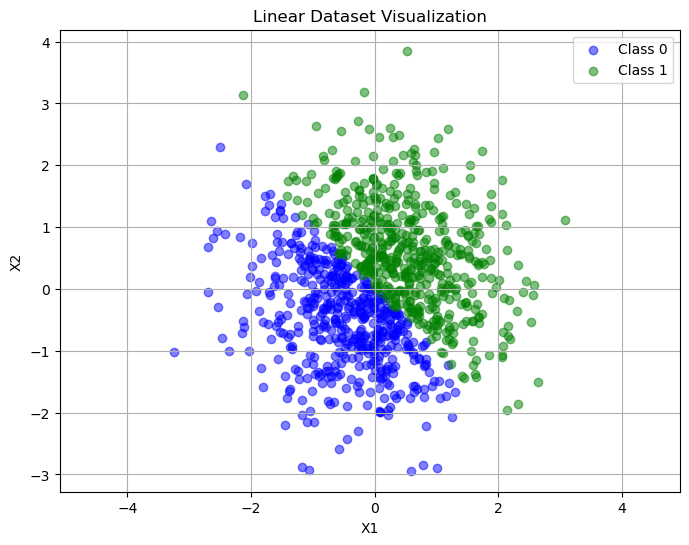

Starting training...
Epoch [100/1000]
Training Loss: 0.6061
Validation Accuracy: 0.8750

Epoch [200/1000]
Training Loss: 0.5501
Validation Accuracy: 0.8700

Epoch [300/1000]
Training Loss: 0.5022
Validation Accuracy: 0.9050

Epoch [400/1000]
Training Loss: 0.4589
Validation Accuracy: 0.9450

Epoch [500/1000]
Training Loss: 0.4193
Validation Accuracy: 0.9650

Epoch [600/1000]
Training Loss: 0.3831
Validation Accuracy: 0.9800

Epoch [700/1000]
Training Loss: 0.3504
Validation Accuracy: 0.9800

Epoch [800/1000]
Training Loss: 0.3210
Validation Accuracy: 0.9800

Epoch [900/1000]
Training Loss: 0.2947
Validation Accuracy: 0.9850

Epoch [1000/1000]
Training Loss: 0.2712
Validation Accuracy: 0.9900



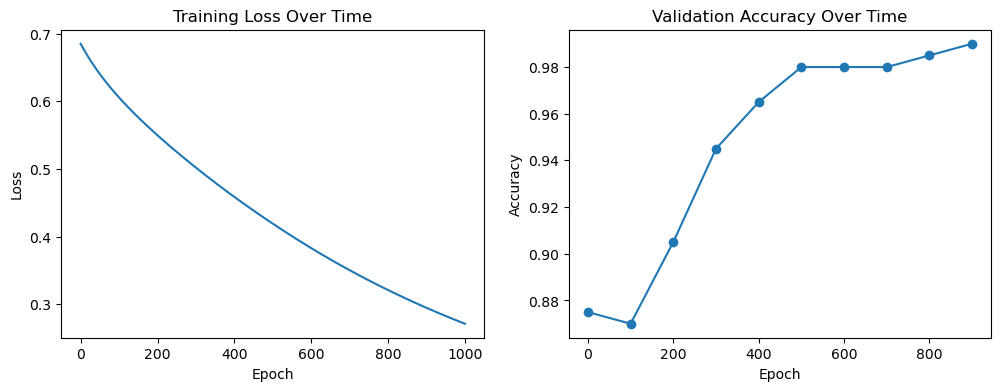


Test Accuracy: 1.0000


In [82]:
model = SimpleNN()
optimizer = 'SGD'
classifier = BinaryClassifier(model, device, optimizer)
data_manager = DataManager(device)

# Prepare data
X, y = data_manager.generate_data()  # Linear data
data_manager.plot_dataset(X, y, "Linear Dataset Visualization")

# Split and convert data
(X_train, y_train), (X_val, y_val) = data_manager.split_data(X, y)
X_train, y_train = data_manager.to_tensor(X_train, y_train)
X_val, y_val = data_manager.to_tensor(X_val, y_val)

# Initialize and run trainer
trainer = Trainer(classifier, data_manager)
trainer.X_train, trainer.y_train = X_train, y_train
trainer.X_val, trainer.y_val = X_val, y_val

# Train and visualize
trainer.train()
trainer.plot_metrics()

# Test model
test_accuracy = test_model(classifier, device)
print(f'\nTest Accuracy: {test_accuracy:.4f}')

# Complex Neural Network Architecture 

In [99]:
class NonLinearModel(nn.Module):
    def __init__(self, input_size=2, hidden_sizes=[32, 16, 8], output_size=1):
        super(NonLinearModel, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input to first hidden layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        # Hidden layers
        for i in range(len(hidden_sizes)-1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = torch.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x

## Circular Dataset 


Training Non-linear Model on Circular Data...
Starting training...
Epoch [100/1000]
Training Loss: 0.6881
Validation Accuracy: 0.5850

Epoch [200/1000]
Training Loss: 0.6783
Validation Accuracy: 0.6400

Epoch [300/1000]
Training Loss: 0.6690
Validation Accuracy: 0.7150

Epoch [400/1000]
Training Loss: 0.6601
Validation Accuracy: 0.7400

Epoch [500/1000]
Training Loss: 0.6517
Validation Accuracy: 0.7400

Epoch [600/1000]
Training Loss: 0.6436
Validation Accuracy: 0.7400

Epoch [700/1000]
Training Loss: 0.6360
Validation Accuracy: 0.7400

Epoch [800/1000]
Training Loss: 0.6287
Validation Accuracy: 0.7400

Epoch [900/1000]
Training Loss: 0.6218
Validation Accuracy: 0.7400

Epoch [1000/1000]
Training Loss: 0.6153
Validation Accuracy: 0.7400



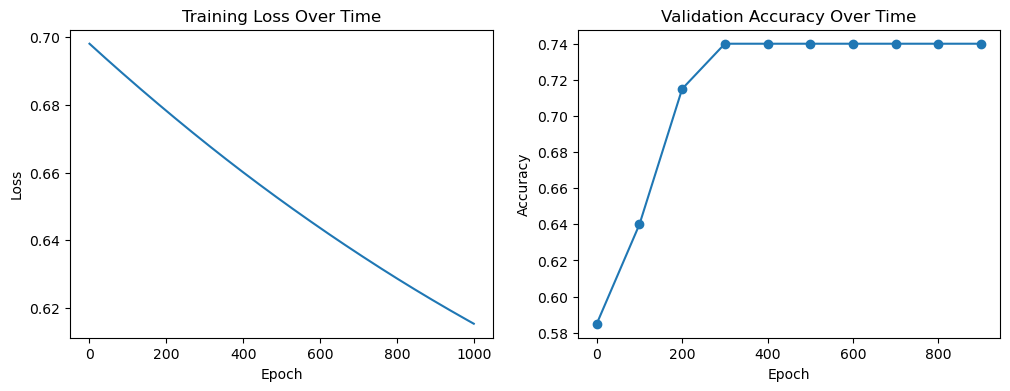

In [86]:

print("Training Non-linear Model on Circular Data...")
model_nonlinear = NonLinearModel().to(device)
classifier_nonlinear = BinaryClassifier(model_nonlinear, device, learning_rate=0.001)

# Generate circular data
X, y = data_manager.generate_circular_data()
(X_train, y_train), (X_val, y_val) = data_manager.split_data(X, y)
X_train, y_train = data_manager.to_tensor(X_train, y_train)
X_val, y_val = data_manager.to_tensor(X_val, y_val)

# Train
trainer = Trainer(classifier_nonlinear, data_manager)
trainer.X_train, trainer.y_train = X_train, y_train
trainer.X_val, trainer.y_val = X_val, y_val
trainer.train()
trainer.plot_metrics()

In [87]:
# Test model
test_accuracy = test_model(classifier, device)
print(f'\nTest Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.9800


## XOR Dataset

### Using a Simple Neural network Architecture 

In [94]:
def test_model_xor(classifier, device, n_test=100):
    """Test model on XOR test cases"""
    test_cases = torch.rand(n_test, 2).to(device) * 2 - 1  # Uniform [-1,1]
    with torch.no_grad():
        outputs = classifier.model(test_cases)
        predictions = torch.sigmoid(outputs)
        predicted_classes = (predictions >= 0.5).float()
        # XOR condition: points in same-sign quadrants are class 1
        expected_classes = ((test_cases[:, 0] * test_cases[:, 1]) > 0).float().view(-1, 1)
        accuracy = (predicted_classes == expected_classes).float().mean()
    return accuracy.item()

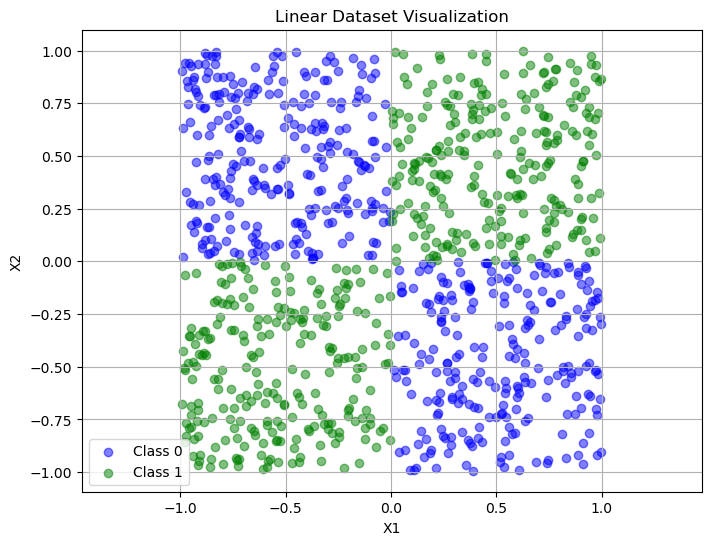

Starting training...
Epoch [100/1000]
Training Loss: 0.7061
Validation Accuracy: 0.4700

Epoch [200/1000]
Training Loss: 0.6971
Validation Accuracy: 0.4700

Epoch [300/1000]
Training Loss: 0.6923
Validation Accuracy: 0.4700

Epoch [400/1000]
Training Loss: 0.6892
Validation Accuracy: 0.4700

Epoch [500/1000]
Training Loss: 0.6870
Validation Accuracy: 0.4700

Epoch [600/1000]
Training Loss: 0.6851
Validation Accuracy: 0.4700

Epoch [700/1000]
Training Loss: 0.6833
Validation Accuracy: 0.4700

Epoch [800/1000]
Training Loss: 0.6815
Validation Accuracy: 0.4700

Epoch [900/1000]
Training Loss: 0.6796
Validation Accuracy: 0.4700

Epoch [1000/1000]
Training Loss: 0.6775
Validation Accuracy: 0.4700



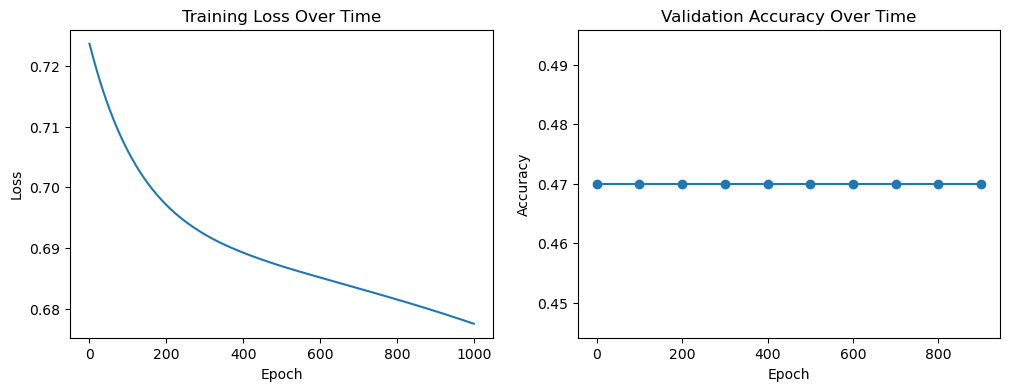


Test Accuracy: 0.4900


In [100]:
model = SimpleNN()
optimizer = 'SGD'
classifier = BinaryClassifier(model, device, optimizer)
data_manager = DataManager(device)

# Prepare data
X, y = data_manager.generate_xor_data()  # Linear data
data_manager.plot_dataset(X, y, "Linear Dataset Visualization")

# Split and convert data
(X_train, y_train), (X_val, y_val) = data_manager.split_data(X, y)
X_train, y_train = data_manager.to_tensor(X_train, y_train)
X_val, y_val = data_manager.to_tensor(X_val, y_val)

# Initialize and run trainer
trainer = Trainer(classifier, data_manager)
trainer.X_train, trainer.y_train = X_train, y_train
trainer.X_val, trainer.y_val = X_val, y_val

# Train and visualize
trainer.train()
trainer.plot_metrics()

# Test model
test_accuracy = test_model_xor(classifier, device)
print(f'\nTest Accuracy: {test_accuracy:.4f}')

### Using a Complex Neural network Architecture 

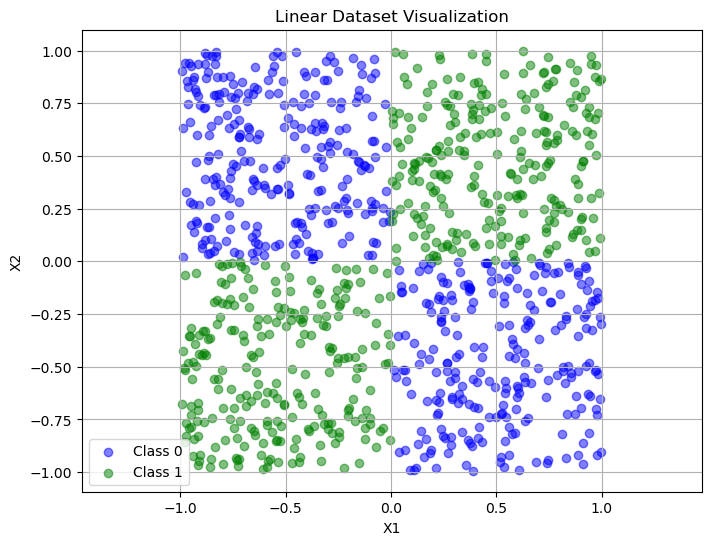

Starting training...
Epoch [100/1000]
Training Loss: 0.6925
Validation Accuracy: 0.5300

Epoch [200/1000]
Training Loss: 0.6914
Validation Accuracy: 0.7200

Epoch [300/1000]
Training Loss: 0.6903
Validation Accuracy: 0.5950

Epoch [400/1000]
Training Loss: 0.6893
Validation Accuracy: 0.5650

Epoch [500/1000]
Training Loss: 0.6882
Validation Accuracy: 0.5450

Epoch [600/1000]
Training Loss: 0.6871
Validation Accuracy: 0.5300

Epoch [700/1000]
Training Loss: 0.6858
Validation Accuracy: 0.5400

Epoch [800/1000]
Training Loss: 0.6843
Validation Accuracy: 0.5600

Epoch [900/1000]
Training Loss: 0.6825
Validation Accuracy: 0.5850

Epoch [1000/1000]
Training Loss: 0.6804
Validation Accuracy: 0.6300



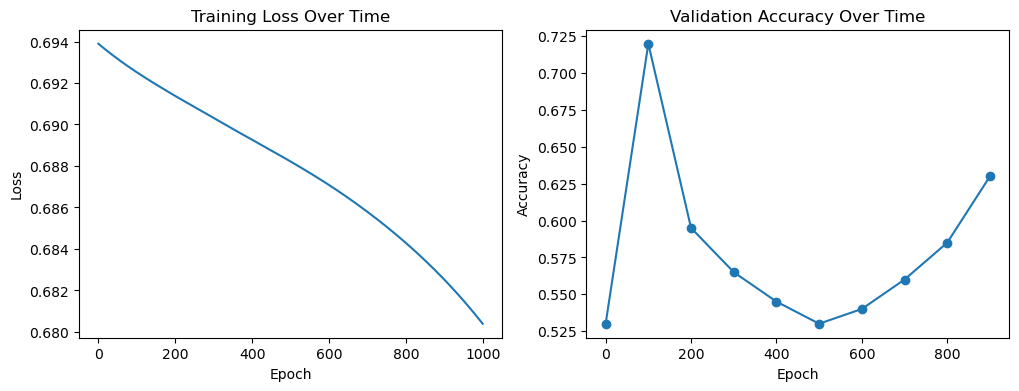


Test Accuracy: 0.6500


In [101]:
model = NonLinearModel()
classifier = BinaryClassifier(model, device)
data_manager = DataManager(device)

# Prepare data
X, y = data_manager.generate_xor_data()  # Linear data
data_manager.plot_dataset(X, y, "Linear Dataset Visualization")

# Split and convert data
(X_train, y_train), (X_val, y_val) = data_manager.split_data(X, y)
X_train, y_train = data_manager.to_tensor(X_train, y_train)
X_val, y_val = data_manager.to_tensor(X_val, y_val)

# Initialize and run trainer
trainer = Trainer(classifier, data_manager)
trainer.X_train, trainer.y_train = X_train, y_train
trainer.X_val, trainer.y_val = X_val, y_val

# Train and visualize
trainer.train()
trainer.plot_metrics()

# Test model
test_accuracy = test_model_xor(classifier, device)
print(f'\nTest Accuracy: {test_accuracy:.4f}')